In [155]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import copy
from tqdm import tqdm
import random
import warnings
import csv


In [204]:
m_zp = {"u":26.52, "g":28.51,"r":28.36, "i": 28.17, "z":27.78, "y":26.82} # https://smtn-002.lsst.io/#photometric-zeropoints
m_sat = {'u':14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9} # https://www.lsst.org/scientists/keynumbers
m_5 = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45} # https://smtn-002.lsst.io/#calculating-m5
band_colors = {'u': 'b', 'g': 'c', 'r': 'g', 'i': 'orange', 'z': 'r', 'y': 'm'}
MAIN_FOLDER = "DataSets"
PLOTS = "Visualization"
bands = "ugrizY"

class LightCurve:
    def __init__(self, id=None, band=None, mjd=None, flux=None, flux_err=None, mag=None, mag_err=None, source="txt", select="snid", file_path=None, zp=27.5):
        self.band = band.lower()
        self.mjd = mjd
        self.flux = flux
        self.flux_err = flux_err
        self.mag, self.mag_err = self.flux_to_mag(flux, flux_err, zp=m_zp[self.band]) if (flux and flux_err) else mag, mag_err
        self.id = id
        self.snid = None
        self.zp = None
                
    @staticmethod
    def flux_to_mag(flux, flux_err=None, zp=27.5):
        if flux_err is not None:
            top = flux + flux_err
            bot = flux - flux_err
            top_mag = zp - 2.5 * np.log10(np.abs(top))
            bot_mag = zp - 2.5 * np.log10(np.abs(bot))
            return zp - 2.5 * np.log10(np.abs(flux)), np.abs(top_mag - bot_mag)
        else:
            return zp - 2.5 * np.log10(np.abs(flux)), None

    def load_snana(self, phot, head, snid=None, idx=None):
        if snid:
            start = head[head["SNID"] == snid]["PTROBS_MIN"][0]
            end = head[head["SNID"] == snid]["PTROBS_MAX"][0]
            self.snid = snid
        elif idx:
            start, end = head["PTROBS_MIN"][idx], head["PTROBS_MAX"][idx]
            self.snid = head["SNID"][idx]
        lc_band = phot[start:end][phot[start:end]["BAND"].lower() == self.band.lower()]
        self.mjd = lc_band["MJD"]
        self.flux = lc_band["FLUXCAL"]
        self.flux_err = lc_band["FLUXCALERR"]
        self.zp = lc_band["ZEROPT"]
        self.mag, self.mag_err = self.flux_to_mag(self.flux, self.flux_err)
        
    def save_file(self, path, snid=True):
        """Save light curve data to a text file."""
        if snid:
            path = Path(path,f"lc_{self.snid}_{self.band}.dat")
        with open(path, 'w') as f:
            for mj, m, merr in zip(self.mjd, self.mag, self.mag_err):
                f.write(f"   {mj:.3f}  {m:.4f}   {merr:.3f}\n")
            f.write('\n')

    def plot(self, title=None, fig=None, ax=None, show=True, save=None):
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        ax.errorbar(self.mjd, self.mag, self.mag_err, fmt='o', color=band_colors[self.band], label=f"Band {self.band}", alpha=0.8)
        ax.set_xlabel("MJD")
        ax.set_ylabel("Magnitude")
        if not title:
            title = f"Light curve"
        ax.set_title(title)
        ax.invert_yaxis()
        ax.legend(loc=(1.01,0))
        if show:
            plt.show()
        if save:
            plt.savefig(save)
        return fig, ax

    def cut_m_sat(self, m_sat):
        mask = (self.mag >= m_sat) & (self.mag != np.inf)
        new_mjd = self.mjd[mask]
        new_mag = self.mag[mask]
        new_mag_err = self.mag_err[mask]
        del_points = len(self.mag) - len(new_mag)
        self.mjd, self.mag, self.mag_err = new_mjd, new_mag, new_mag_err
        return del_points

    def cut_m_5(self, m_5, N_points=10, N_sigma=1):
        n_high_snr = np.sum(self.mag + N_sigma * self.mag_err < m_5)
        return n_high_snr > N_points

    def cut_has_peak(self, N_points=4, N_sigma=3):
        median = np.median(self.mag)
        n_high_m = np.sum(self.mag + N_sigma * self.mag_err < median)
        return n_high_m > N_points

    def cut_chi2_dof(self, cte, upper_limit=None):
        chi = ((self.mag - cte) ** 2) / (self.mag_err ** 2)
        chi2_dof = np.sum(chi) / len(self.mag)
        if upper_limit is None:
            return chi2_dof
        else:
            return chi2_dof > upper_limit, chi2_dof

    def cut_has_variability(self, N_points=4, N_sigma=3):
        median = np.median(self.mag)
        n_distant_m = np.sum(np.abs(self.mag - median) > N_sigma * self.mag_err)
        return n_distant_m > N_points

    def apply_cuts(self, m_5=None, m_sat=None, upper_limit=None, cuts="all"):
        results = {}
        if cuts == "all":
            cuts = ["m_sat", "m_5", "has_peak", "high_chi2", "chi", "has_variability", "median"]

        if "m_sat" in cuts:
            del_points = self.cut_m_sat(m_sat)
            results["del_points"] = del_points

        if "m_5" in cuts:
            valid = self.cut_m_5(m_5)
            results["valid"] = valid

        if "high_chi2" in cuts:
            high_chi2, chi = self.cut_chi2_dof(np.median(self.mag), upper_limit)
            results["high_chi2"] = high_chi2
            results["chi"] = chi

        if "has_peak" in cuts:
            has_peak = self.cut_has_peak()
            results["has_peak"] = has_peak

        if "has_variability" in cuts:
            has_variability = self.cut_has_variability()
            results["has_variability"] = has_variability

        if "median" in cuts:
            median = np.median(self.mag)
            results["median"] = median

        return results
        
def fit_from_category(dataset, category, n_fit, main_folder=MAIN_FOLDER, search_cat=True):
    """
    Retrieves FITS data from specified category and fit file number.

    Parameters:
        dataset (str): Name of the dataset folder within main_folder.
        category (str): Category name to retrieve data from.
        n_fit (int): Number of the fit file to retrieve.
        main_folder (str, optional): Path to the main folder containing the dataset.
        search_cat (bool, optional): If True, prepends a common prefix to the category name for matching.

    Returns:
        tuple: A tuple containing:
            - phot (FITS data): Photometry data from the specified FITS file.
            - head (FITS data): Header data from the specified FITS file.
    """
    if search_cat:
        pref_cat = os.path.commonprefix(os.listdir(Path(MAIN_FOLDER, DATASET)))
        category = pref_cat+category
    category_path = Path(MAIN_FOLDER, DATASET, category)
    
    fits_files =[file for file in os.listdir(category_path) if file.endswith("FITS.gz")]
    pref = os.path.commonprefix(fits_files)
    n_fit="{:02d}".format(n_fit)
    head = fits.open(Path(category_path, pref+f"{n_fit}_HEAD.FITS.gz"))[1].data
    phot = fits.open(Path(category_path, pref+f"{n_fit}_PHOT.FITS.gz"))[1].data
    return phot, head

def create_dataset(dataset, bands=bands, categories=None, n_snids=None, random_select=True, 
                          main_folder=MAIN_FOLDER, search_cat=False, 
                          cuts=None, upper_limit=None, name=None):
    """
    Generates and saves light curves for specified categories, bands, and SNIDs.

    Parameters:
        dataset (str): Name of the dataset folder to be formatted within the main_folder.
        bands (str): Bands to process (e.g., "gri").
        categories (list, optional): List of categories to include; defaults to all categories in the dataset.
        n_snids (int, optional): Number of SNIDs (light curves) to process per category; if None, processes all SNIDs.
        random_select (bool, optional): If True, selects SNIDs randomly; if False, selects them in order.
        main_folder (str, optional): Path to the main folder where the dataset is located.
        search_cat (bool, optional): If True, searches for categories containing a substring match in directory names.
        cuts (list, optional): List of cuts to apply; if None, no cuts are applied. Available cuts: 
                               ["m_sat", "m_5", "has_peak", "high_chi2", "has_variability"].
        upper_limit (float, optional): Upper limit for chi-squared cut.
        name (str, optional): Custom name for the new dataset; if None, generates an automatic name.

    Functionality:
        - Creates a new folder structure for each specified band and category within the main_folder.
        - For each category, retrieves and processes specified SNIDs.
        - Applies specified cuts and saves the light curve data to the respective category folder for each band.
        - Creates a CSV file listing the applied cuts.
    """

    if name is None:
        n = 1
        name = f"{dataset}_new{n}"
        while Path(main_folder, name).exists():
            n += 1
            name = f"{dataset}_new{n}"

    new_dataset = Path(main_folder, name)
    new_dataset.mkdir(parents=True, exist_ok=True)

    categories = categories or os.listdir(Path(main_folder, dataset))

    for band in bands:
        band_folder = new_dataset
        band_folder.mkdir(parents=True, exist_ok=True)
        with open(band_folder / f"cuts_applied_{band}.csv", 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['SNID'] + (cuts if cuts else [])
            writer.writerow(header)

            for categ in categories:
                if search_cat:
                    categ = next((c for c in os.listdir(Path(MAIN_FOLDER, dataset)) if categ in c), None)
                category_folder = band_folder / categ
                category_folder.mkdir(parents=True, exist_ok=True)
        
                for n_fit in range(1, 41):
                    phot, head = fit_from_category(new_dataset, categ, n_fit, main_folder=main_folder, search_cat=False)
                    snids = head["SNID"]
                    selected_snids = (random.sample(list(snids), n_snids) if random_select else snids[:n_snids])
                    
                    cut_results_summary = []
        
                    for snid in tqdm(selected_snids, desc=f"Categ: {categ} - FIT_FILE: {n_fit} - Band: {band}"):
                        lc = LightCurve(band=band)
                        lc.load_snana(phot, head, snid=snid)
        
                        current_m_5 = m_5[band] if "m_5" in cuts else None
                        current_m_sat = m_sat[band] if "m_sat" in cuts else None
        
                        cut_results = {}
                        if cuts:
                            cut_results = lc.apply_cuts(m_5=current_m_5, m_sat=current_m_sat, upper_limit=upper_limit, cuts=cuts)
                            cut_results["snid"] = snid
                            cut_results_summary.append(cut_results)

                            # Check if all cuts passed
                            if not all(cut_results.values()): 
                                continue
        
                        lc.save_file(category_folder)
                        row = [cut_results.get("snid")] + [cut_results.get(cut, False) for cut in cuts]
                        writer.writerow(row)

### Data structure (SNANA output):

Files tree:
```plaintext
project_root/
│
├── MAIN_FOLDER/
│   ├── CATEGORY1/
│   │   └── *_HEAD.FITS.gz
│   │   └── *_PHOT.FITS.gz
│   ├── CATEGORY2/
│   │   └── *_HEAD.FITS.gz
│   │   └── *_PHOT.FITS.gz
│   └── ...
│
└── PLOTS/

Fits files:
* HEAD.FITS.gz: Events data
  * Location (ra, dec)
  * Number of observations (NOBS)
  * Reference index to find its photometry in the PHOT file:
    * 1st point (PTROBS_MIN)
    * last point (PTROBS_MAX)
* PHOT.FITS.gz: Observation data
  * MJD
  * Flux (FLUXCAL) 
  * Flux error (FLUXCALERR)
  * Zero point
  * Filter 

In [176]:
pref_cat = os.path.commonprefix(os.listdir(Path(MAIN_FOLDER, DATASET)))
category_path = Path(MAIN_FOLDER, DATASET, pref_cat+CATEGORY)
fits_files =[file for file in os.listdir(category_path) if file.endswith("FITS.gz")]
pref = os.path.commonprefix(fits_files)
head = fits.open(Path(category_path, pref+"{:02d}".format(n_fit)+"_HEAD.FITS.gz"))[1]
phot = fits.open(Path(category_path, pref+"{:02d}".format(n_fit)+"_PHOT.FITS.gz"))[1]
phot_df = pd.DataFrame(phot.data)
head_df = pd.DataFrame(head.data)
print(phot_df.columns)
print(head_df.columns)

Index(['MJD', 'BAND', 'CCDNUM', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL',
       'FLUXCALERR', 'PSF_SIG1', 'PSF_SIG2', 'PSF_RATIO', 'SKY_SIG',
       'SKY_SIG_T', 'RDNOISE', 'ZEROPT', 'ZEROPT_ERR', 'GAIN', 'XPIX', 'YPIX',
       'SIM_FLUXCAL_HOSTERR', 'SIM_MAGOBS'],
      dtype='object')
Index(['SNID', 'IAUC', 'FAKE', 'RA', 'DEC', 'PIXSIZE', 'NXPIX', 'NYPIX',
       'SNTYPE', 'NOBS',
       ...
       'SIM_TEMPLATEMAG_i', 'SIM_TEMPLATEMAG_z', 'SIM_TEMPLATEMAG_Y',
       'SIM_EXPOSURE_u', 'SIM_EXPOSURE_g', 'SIM_EXPOSURE_r', 'SIM_EXPOSURE_i',
       'SIM_EXPOSURE_z', 'SIM_EXPOSURE_Y', 'SIM_SUBSAMPLE_INDEX'],
      dtype='object', length=145)


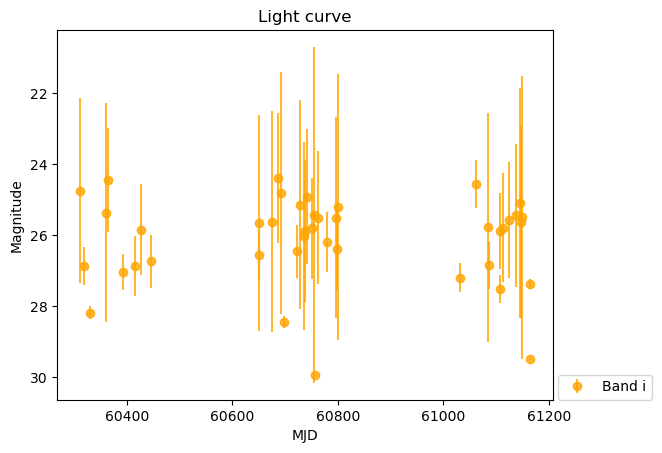

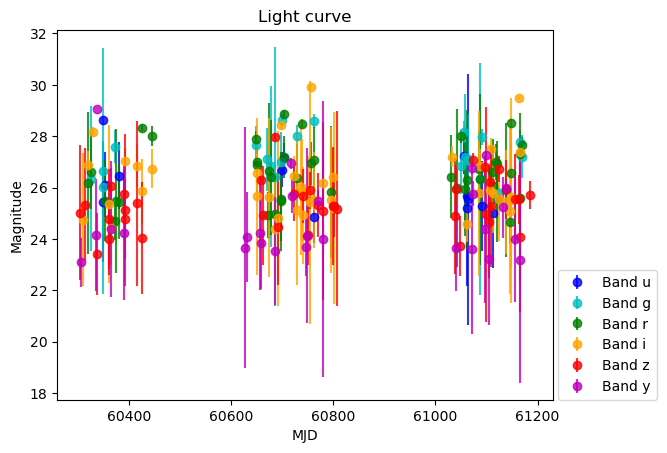

In [146]:
MAIN_FOLDER = "DataSets"
DATASET = "FULL_ELASTICC_TRAIN"
CATEGORY = "Mdwarf-flare"
n_fit = 1 
phot, head = fit_from_category(DATASET, CATEGORY, n_fit, main_folder=MAIN_FOLDER)
idx = 2
lc = LightCurve(band="i")
lc.load_snana(phot, head, idx=idx)
lc.plot()

for band in bands:
    lc = LightCurve(band=band)
    lc.load_snana(phot, head, idx=idx)
    if band == bands[0]:
        fig, ax = lc.plot(show=False)
    elif band == bands[-1]:
        lc.plot(fig=fig, ax=ax)
    else:
        lc.plot(fig=fig, ax=ax, show=False)

In [175]:
# Formatting the entire data set
generate_light_curves(dataset=DATASET)

Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 1 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 2 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 3 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 4 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 5 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 6 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 7 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 8 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 9 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 10 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 11 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 12 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf

In [203]:
# Customize as needed (example)
generate_light_curves(
    dataset=DATASET,               # Data set to transform
    bands="ri",                    # Filters of interest
    categories=["Mdwarf-flare"],   # Categories of interest
    n_snids=20,                    # number of light curves to transform            
    random_select=True ,           # Select the light curves randomly?
    search_cat=True,               # If the input is the exact name of the folder or just the category name
    cuts=['has_variability'])      # Cuts to be applied to the light curves


Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 1 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 2 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 3 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 4 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 5 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 6 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 7 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 8 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 9 - Band: r: 100%|█| 5/5 [00:00<0
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 10 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 11 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf-flare - FIT_FILE: 12 - Band: r: 100%|█| 5/5 [00:00<
Categ: ELASTICC_TRAIN_Mdwarf

KeyboardInterrupt: 